Which object do you want to use to generate data ?

>> poivre
Which antenna do you want to choose to extract the data ?

>> Antenna 
Antenna not found
>> Antenna 1


|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| Time:  0:00:05 |<<<<<<<<<<<<<<<<<<<<<<<<<<<<<|


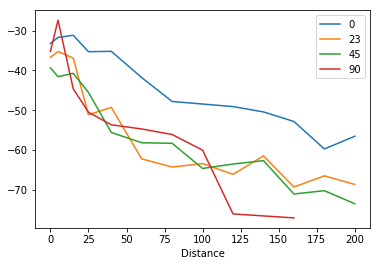

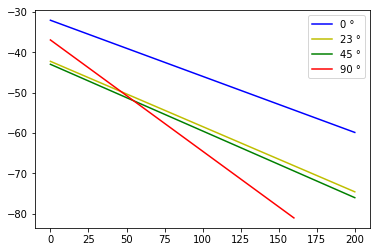

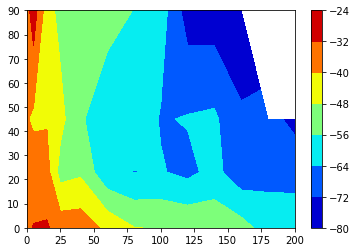

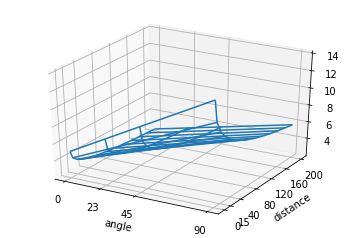

In [12]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import datetime
import pandas_datareader as pdr
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import glob, os
import time
import sys
import inspect
import fileinput
import scipy
from scipy import stats
import math

from progressbar import AnimatedMarker, Bar, BouncingBar, Counter, ETA, \
    AdaptiveETA, FileTransferSpeed, FormatLabel, Percentage, \
    ProgressBar, ReverseBar, RotatingMarker, \
SimpleProgress, Timer

#fonction qui renvoie le bon path
def getPath() :
    
    #Renvoie le path courant aussi
    #print(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))))

    #Path courant
    cwd = os.getcwd()
    #C:\Users\laure\WebSocketClientCSharp\WebSocketClient\generate

    #On va changer de path (cwd, '../WebSocketClient/bin/Debug/xp/'))
    os.chdir('../xp/')
    
    #print("Path changed. New path is : "+ os.getcwd())

    return;

# ------------------- CREATION FICHIER FINAL : CONTIENT TOUTES LES MOYENNES ----------------
def finalDataExist() :
    #On va remplir le fichier final : tester s'il existe
    #Si le fichier n'existe pas on le crée
    
    if os.path.isfile('data/finalData.csv') is True:
        os.remove('data/finalData.csv')
    
    #On le créer
    open('data/finalData.csv', 'a').close()        
        
    #On écrit le nom des colonnes
    with open('data/finalData.csv', 'a') as the_file:
        the_file.write('Distance;0;23;45;90')
        the_file.write('\n')
    #else:
        
    return;

# ------------------- VERIFICATION S'IL EXISTE LES DONNEES NECESSAIRES POUR LES GRAPHS ----------------
def verifyFiles() :
    
    ok = False
    print("Which object do you want to use to generate data ?\n")
    
    while(ok is False):
        
        answer = input(">> ")
        
        if answer == '__pycache__':
            print("Do not try to fool me !")
        
        if answer == 'exit':
            sys.exit("The program will shut down now.")
        
        #Si la réponse est un dossier qui existe
        if os.path.isdir(answer):
            #On compte le nombre de fichier à l'intérieur (non récursif)
            numfiles = len([f for f in os.listdir(answer) if os.path.isfile(os.path.join(answer, f)) and f[0] != '.'])        
        
            #Le nombre total de fichiers csv
            if numfiles != 52:
                print("Not enough data ! Make sure you collected all the necessary data before you execute this script")
                print("Please, enter the name of the directory again")

            #Si le dossier existe ET qu'il y a assez de fichiers pour générer les données alors c'est bon
            else:
                ok = True
                
        #Si le dossier n'existe pas alors cela veut dire que l'on ne possède pas assez de données
        else:
            print("The data's object doesn't exist. Make sure you collected all the necessary data before you execute this script")
            print("Please, enter the name of the directory again")
    
    os.chdir(answer)
    return;

#Fonction permettant de delete tous les graphs et images
def clearAll() :
    
    folders = ['data/2d','data/3d','data/2ddistanceangle','data/heatmap','data/2dlinregress','data']
    
    for temp in folders:
    
        for the_file in os.listdir(temp):
            file_path = os.path.join(temp, the_file)
        
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
        
                #elif os.path.isdir(file_path): shutil.rmtree(file_path)
            except Exception as e:
                print(e)
    
    return;
    
def generationHeatMap() :
    
    #Separé par des ; donc l'index est la première colonne
    df = pd.read_csv('data/finalData.csv',sep=';',index_col=0)

    #notre X sera l'index : la distance
    x = df.index

    #notre Y sera l'index : la distance
    y = df.columns.astype(int)

    df.values.astype(float)
    z = df.values

    X,Y = np.meshgrid(x,y)
    Z = z.T
    plt.contourf(X,Y,Z,cmap='jet')

    plt.colorbar()
    plt.savefig('data/heatmap/{}.png'.format('heatmap'))

    plt.show()
    plt.close()
    

    return;

def generation2DDistanceAngle() :
    
    #Separé par des ; donc l'index est la première colonne
    df = pd.read_csv('data/finalData.csv',sep=';',index_col=0)

    #print(df)

    df=df.astype(float)
    
    fig = df.plot().get_figure()
    fig.savefig("data/2ddistanceangle/output.png")
    plt.show()
    plt.close(fig)
    
    return;

def generationWireFrame() :
    
    raw_data = np.loadtxt('data/finalData.csv', delimiter=';', dtype=np.string_)

    angle    = raw_data[0 , 1:].astype(float)
    distance = raw_data[1:, 0 ].astype(float)
    data     = raw_data[1:, 1:].astype(float)


    #Données à l'intérieur de la matrice
    data = (50 + angle[np.newaxis,:]) / (10 + np.sqrt(distance[:,np.newaxis])) 

    #Setup du plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    #Créer les données que le wireframe souhaite
    Z = data
    X, Y = np.meshgrid(angle, distance)

    ax.plot_wireframe(X, Y, Z)

    #Legendes
    ax.set_xticks(angle)
    ax.set_yticks(distance[::2])
    ax.set_xlabel('angle')
    ax.set_ylabel('distance')

    #On la'ffiche et on l'enregistre
    plt.savefig('data/3d/3d.png')
    plt.show()
    
    return;

def generateRegress() :
    
    #Separé par des ; donc l'index est la première colonne
    df = pd.read_csv('data/finalData.csv',sep=';',index_col=0)

    angles = ['0','23','45','90']
    numpyAngles = np.array(['0','23','45','90'])

    distances = [0,5,15,25,40,60,80,100,120,140,160,180,200]
    numpyDistances = np.array([0,5,15,25,40,60,80,100,120,140,160,180,200])

    y = np.array([])

    colors = ['b','y','g','r']
    i = 0

    #Pour tous les angles (ie. pour toutes les courbes) on va faire une régression linéaire
    for a in angles:
        
        index = 0
        tabDelete = []
        #On va faire un tableau de toutes les valeurs RSSI
        for d in distances :
            
            #On récupère le RSSI pour le couple angle/distance
            temp = df[a].get(d)
    
            #Sinon cela veut dire que pour la distance / angle on a pas de données donc on ignore le temp et on supprime le X correspondant
            if str(temp) == 'nan':
                tabDelete.append(index)
            else:
                #On le push dans le numpy array
                y = np.append(y,[temp])
                
            index = index + 1
            
        numpyDistances = np.delete(numpyDistances,tabDelete)
            
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(numpyDistances,y)
        plt.plot(numpyDistances, intercept + slope*numpyDistances, colors[i], label=a+' °')
        i = i+1
        
        #On vide le tableau des Y : dans Y on a un tableau vide
        y = np.array([])
        numpyDistances = np.array([0,5,15,25,40,60,80,100,120,140,160,180,200])
        
    #On fait la meme chose pour tous les angles qui suivent...
    
    #On affiche les plots
    plt.legend()
    plt.savefig('data/2dlinregress/2dlinregress.png')
    plt.show()
    
    return;

def setupBar() :
    widgets = [Bar('>'), ' ', ETA(), ' ', ReverseBar('<')]
    pbar = ProgressBar(widgets=widgets, maxval=52).start()
    
    return pbar;

def chooseAntenna() :
    
    #Fonction qui permet de choisir de générer les données pour une antenne
    ok = False
    print("Which antenna do you want to choose to extract the data ?\n")
    
    antennas = [1,2,3,4,5,6,7,8]
    
    while ok is False :

        answer = input(">> Antenna ")
        
        if answer == 'exit':
            sys.exit("The program will shut down now.")
        
        x = 0
        found = False
        
        #Tant qu'on a pas trouvé et que X est plus petit que la taille du array
        
        while found is False and x < len(antennas) :
            
            #Si la réponse existe dans le tableau des antennes
            
            temp = str(antennas[x])
            if temp == answer:
                
                found = True
                ok = True
                antenna = "rssi"+str(x+1)
            
            x=x+1
                
        if found is False:
            print("Antenna not found")
    
    return antenna;

# Fonction permettant de vérifier que le format ne contient pas des \t à la place des ; pour les CSV
# En effet, il s'est avéré que des fois dans certains fichiers des \t remplaçaient les ;

def reformatCSV(filePath) :
    with fileinput.FileInput(filePath, inplace=True) as file:
        for line in file:
            print(line.replace('\t', ";"), end='')
    return;

#------------------------------------------------------------------
#on va générer les csv des moyennes pour chaque Angle
#On va parcourir tous les CSV ayant la même distance pour un angle
#Faire la moyenne des données dans le fichier CSV
#...
#------------------------------------------------------------------

#IN CASE OF UNINTENDED INTERRUPTION OF THE SCRIPT : PLEASE UNCOMMENT THE NEXT LINE WITH THE GOOD PATH
# ---------- 'C:/path/to/add/WebSocketClientCSharp/WebSocketClient/WebSocketClient/bin/Debug/generate' ----------
#os.chdir('C:/Users/laure/WebSocketClientCSharp/WebSocketClient/WebSocketClient/bin/Debug/generate')

#On change le directory
getPath()

verifyFiles()

antenna = chooseAntenna()

#On va nettoyer les potentiels anciens fichiers
clearAll()

#Liste des angles permettant d'effectuer les lectures pour les algo
distances = ['0','5','15','25','40','60','80','100','120','140','160','180','200']

finalDataExist()

#On est dans le folder de l'objet courant

#On va setup la progressBar

pbar = setupBar()
ite = 1

for (i, distance) in enumerate(distances):
    #i = index
    #distance = distance courante
    
    #Nous allons stocker les moyennes des RSSI pour chaque couple distance/angle
    averagesRSSI = {}
    
    for file in glob.glob("*.csv"):
        #nom du fichier
        #print(file)
        
        #On sépare le nom du fichier pour savoir si l'angle est le bon
        parts = file.split('_')
        
        #On récupère la distance courante
        #Avec cette distance on va lire tous les fichiers qui concernent cette distance
        #créer une ligne pour append dans le csv final
        
        #Alors on va lire le fichier
        
        if parts[1] == distance:  
            filePath = os.getcwd().replace("\\","/")+"/"+file

            # --------------- CONSTRUCTION GRAPHE 2D RSSI / TIME -------------------------
            
            reformatCSV(filePath)
            
            df = pd.read_csv(filePath,sep=';',index_col=0,parse_dates=True)
            
            #Si le fichier n'est pas vide de données
            if df.empty is False :
                #Moyenne
                #On dit que c'est un float
                df[antenna] = df.astype(float)
                average = df[antenna].mean()
                nb = df.shape[0]
            
                #Ecart-type
                standardDeviation = df[antenna].std()
            
                #On va récupérer la moyenne de temps par échantillon
                beginning = df.first_valid_index()
                ending = df.last_valid_index()
                averageTime = (ending - beginning).total_seconds()/nb
            
                #Temps total
                totalTime = (ending - beginning).total_seconds()
            
                #On enregistre l'average RSSI dans le tableau pour l'append dans le finalData.csv
                #EXEMPLE : Sel_0_0.csv alors averageRSSI[0'°'] = moyenne courante
                #Sel_0_23.csv : averageRSSI[23] = moyenne courante
                #...
                averagesRSSI[file.split('_')[2].split('.')[0]] = average
            
                #On va plot (dessiner) le graph de l'évolution du RSSI selon le temps
                plt.ylabel(antenna)
                plt.grid(True)
                df[antenna].plot()
            
                #On affiche la moyenne dans le plot
                plt.axhline(y=average, color='r', linestyle='-')
            
                temp = file.split('.')[0]
                plt.savefig('data/2d/'+temp+'.png')
                plt.close()
            
            #Si le fichier ne contient pas de données et est donc empty
            else:
                temp = file.split('.')[0]
                average = np.nan
                nb = np.nan
                standardDeviation = np.nan
                totalTime = np.nan
                averageTime = np.nan
            
                averagesRSSI[file.split('_')[2].split('.')[0]] = np.nan
                
            #Si le fichier n'existe pas on le crée
            if os.path.isfile('data/data.csv') is False:
                open('data/data.csv', 'a').close()
                
                #On écrit le nom des colonnes
                with open('data/data.csv', 'a') as the_file:
                    the_file.write('Nom;Echantillons;Moyenne;EcartType;TempsTotal;MoyenneTemps')
                    the_file.write('\n')        

            #On écrit les infos
            #Le nom du fichier + nombre d'échantillons + la moyenne + écart type + [autres infos]
            with open('data/data.csv', 'a') as the_file:
                the_file.write(temp+';'+str(nb)+';'+str(average)+';'+str(standardDeviation)+';'+str(totalTime)+';'+str(averageTime))
                the_file.write('\n')
                
            #----------------------------------------------------------------------
            
            #Update de la bar
            pbar.update(ite)
            ite = ite + 1
                
        del parts
    
    #print(averagesRSSI)
    #Maintenant que notre dictionnary des moyennes pour chaque couple Distance / Angle
    
    if bool(averagesRSSI) is True:
        final = distance + ';' + str(averagesRSSI["0"]) + ';'+ str(averagesRSSI["23"]) + ';' + str(averagesRSSI["45"]) + ';' + str(averagesRSSI["90"])
        #print(final)
        
        with open('data/finalData.csv', 'a') as the_file:
                the_file.write(final)
                the_file.write('\n')
    
    
    del averagesRSSI


pbar.finish()

generation2DDistanceAngle()

generateRegress()
    
generationHeatMap()

generationWireFrame()

os.chdir('../')
